In [4]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import argparse
import os
import random
from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import utils
import numpy as np

plt.rcParams['figure.figsize'] = (20, 5)

In [5]:
class parameter:
    def __init__(self):
        self.batch_size = 64
        self.n_past = 5
        self.n_future = 20
        self.num_threads = 16
        self.data_root = '../data_uni'
        self.model_path = './logs/0422_swap_content_disc_wo_time_content_consist/smmnist-2/model=dcgan64x64-rnn_size=256-predictor-posterior-rnn_layers=2-1-n_past=5-n_future=10-lr=0.0020-g_dim=128-z_dim=50-last_frame_skip=0-beta=0.0010000/'
        self.seed = 1
        self.nsample = 100
        self.N = 256

In [6]:
opt = parameter()

In [7]:
opt.log_dir = os.path.join(opt.model_path, 'plots')
opt.model_path = os.path.join(opt.model_path, 'pre_model.pth')
os.makedirs('%s' % opt.log_dir, exist_ok=True)

opt.n_eval = opt.n_past+opt.n_future
opt.max_step = opt.n_eval

print("Random Seed: ", opt.seed)
random.seed(opt.seed)
torch.manual_seed(opt.seed)
torch.cuda.manual_seed_all(opt.seed)
dtype = torch.cuda.FloatTensor

Random Seed:  1


In [8]:
tmp = torch.load(opt.model_path)
# encoder_lstm = tmp['encoder_lstm']
# decoder_lstm = tmp['decoder_lstm']
# content_lstm = tmp['content_lstm']
encoder_c = tmp['encoder_c']
encoder_p = tmp['encoder_p']
decoder = tmp['decoder']
discriminator = tmp['discriminator']

# encoder_lstm.eval()
# decoder_lstm.eval()
# content_lstm.eval()
encoder_c.eval()
encoder_p.eval()
decoder.eval()

# encoder_lstm.batch_size = opt.batch_size
# decoder_lstm.batch_size = opt.batch_size
# content_lstm.batch_size = opt.batch_size
opt.g_dim = tmp['opt'].g_dim
opt.z_dim = tmp['opt'].z_dim
opt.num_digits = tmp['opt'].num_digits

In [9]:
# --------- transfer to gpu ------------------------------------
# encoder_lstm.cuda()
# decoder_lstm.cuda()
# content_lstm.cuda()
encoder_c.cuda()
encoder_p.cuda()
decoder.cuda()
discriminator.cuda()

content_disc(
  (cnn): encoder(
    (c1): dcgan_conv(
      (main): Sequential(
        (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
    (c2): dcgan_conv(
      (main): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
    (c3): dcgan_conv(
      (main): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): LeakyReLU(negative_slope=0.2, inplace)
      )
    )
    (c4): dcgan_conv(
      (main): Sequential(
        (0): Conv2d(256, 512, kernel_size=(4, 4), stride=(

In [10]:
# ---------------- set the options ----------------
opt.dataset = tmp['opt'].dataset
opt.last_frame_skip = tmp['opt'].last_frame_skip
opt.channels = tmp['opt'].channels
opt.image_width = tmp['opt'].image_width

print(opt)

In [11]:
_, test_data = utils.load_dataset(opt)

test_loader = DataLoader(test_data,
                         num_workers=16,
                         batch_size=64,
                         shuffle=True,
                         drop_last=True,
                         pin_memory=True)

/home/minyuan/anaconda3/lib/python3.7/site-packages/torchvision-0.2.1-py3.7.egg/torchvision/transforms/transforms.py:187: UserWarning: The use of the transforms.Scale transform is deprecated, please use transforms.Resize instead.


In [12]:
def get_testing_batch():
    while True:
        for sequence in test_loader:
            batch = utils.normalize_data(opt, dtype, sequence)
            yield batch 
testing_batch_generator = get_testing_batch()

In [13]:
## Forward function for generating global content vector
def forward_content_encoder(x):
    """
    Input: training data
    Return: (vec_c_seq, vec_c_global, skip connection)
    """
    vec_c_seq = [encoder_c(x[i])[0] for i in range(len(x))]
    skip_seq = [encoder_c(x[i])[1] for i in range(len(x))]
    
    return vec_c_seq, skip_seq

## Forward function for encoder part in pose branch
def forward_pose_encoder(x, vec_c_seq):
    """
    Input: x and content vector seq
    Return: pose vector sequence
    """
    vec_p_seq = [encoder_p(x[i], vec_c_seq[i])[0] for i in range(len(x))]
    
    return vec_p_seq
    
## Forward function for decoder
def forward_decoder(vec_p_seq, vec_c_seq, skip_seq):
    """
    Input: pose vec sequence, content vec sequence, skip sequence
    Return: list of predicted frames
    """
    x_pred_list = []
    for vec_p, vec_c, skip in zip(vec_p_seq, vec_c_seq, skip_seq):
        x_pred = decoder([torch.cat([vec_c, vec_p], 1), skip])
        x_pred_list.append(x_pred)
    
    return x_pred_list

## Forward function for discriminator
def forward_discriminator(x1, x2):
    """
    Input: x1 and x2
    """
    out = discriminator(x1, x2)
    return out

In [14]:
x = next(testing_batch_generator)

In [15]:
with torch.no_grad():
    print(len(x))
    vec_c_seq, skip_seq = forward_content_encoder(x)
    skip_zero_seq = []
    for skip in skip_seq:
        skip_zero = [torch.zeros_like(s) for s in skip]
        skip_zero_seq.append(skip_zero)
    vec_p_seq = forward_pose_encoder(x, vec_c_seq)
    x_pred_recon = forward_decoder(vec_p_seq, vec_c_seq, skip_seq)
    x_pred_zero = forward_decoder(vec_p_seq, vec_c_seq, skip_zero_seq)

print(x_pred_recon[0].shape)

25
torch.Size([64, 1, 64, 64])


In [16]:
l2 = []
for recon, gt in zip(x_pred_recon, x):
    l2.append(F.mse_loss(recon, gt).item())
l2

[0.0001360936148557812,
 0.00013539407518692315,
 0.00013723554729949683,
 0.00013485734234564006,
 0.0001364598429063335,
 0.00013571340241469443,
 0.00013666285667568445,
 0.0001362472539767623,
 0.0001362710609100759,
 0.00013657237286679447,
 0.00013606763968709856,
 0.00013499660417437553,
 0.00013655368820764124,
 0.0001363725314149633,
 0.00013825064525008202,
 0.00013650275650434196,
 0.00013852212578058243,
 0.000137460432597436,
 0.0001378722081426531,
 0.00013687703176401556,
 0.00013740474241785705,
 0.00013690939522348344,
 0.00013709551421925426,
 0.00013613890041597188,
 0.00013723828305955976]

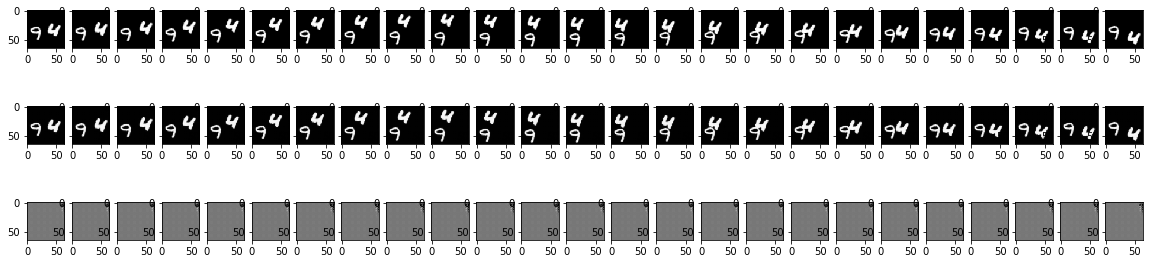

In [17]:
f, axs = plt.subplots(3, len(x))
for i in range(len(x)):
    img_gt = transforms.ToPILImage()(x[i][0].cpu())
    img_recon = transforms.ToPILImage()(x_pred_recon[i][0].cpu())
    img_recon_zero = transforms.ToPILImage()(x_pred_zero[i][0].cpu())
    axs[0][i].imshow(img_gt)
    axs[1][i].imshow(img_recon)
    axs[2][i].imshow(img_recon_zero)
f.savefig('visualization.jpg', dpi=300)

# Swap pose for checking disentanglement

In [18]:
# get next batch
y = next(testing_batch_generator)

In [19]:
with torch.no_grad():
    vec_c_seq_y, skip_seq_y = forward_content_encoder(y)
    vec_p_seq_y_Cy = forward_pose_encoder(y, vec_c_seq_y)
    vec_p_seq_y_Cx = forward_pose_encoder(y, vec_c_seq)
    
    x_pred_recon_y_skip = forward_decoder(vec_p_seq, vec_c_seq, skip_seq_y)
    x_pred_recon_Ey_Dy = forward_decoder(vec_p_seq_y_Cy, vec_c_seq_y, skip_seq_y)
    x_pred_recon_Ex_Dx = forward_decoder(vec_p_seq_y_Cx, vec_c_seq, skip_seq)
    x_pred_recon_Ey_Dx = forward_decoder(vec_p_seq_y_Cy, vec_c_seq, skip_seq)

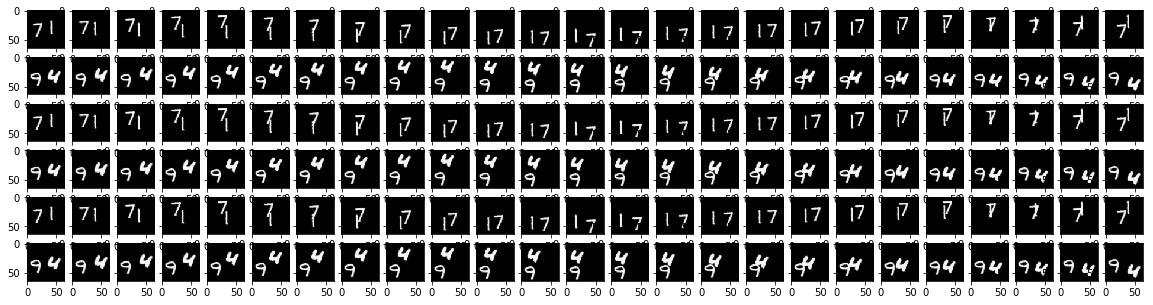

In [20]:
f, axs = plt.subplots(6, len(x))
for i in range(len(x)):
    img_y = transforms.ToPILImage()(y[i][0].cpu())
    img_x = transforms.ToPILImage()(x[i][0].cpu())
    img_recon_y_skip = transforms.ToPILImage()(x_pred_recon_y_skip[i][0].cpu())
    img_recon_Ex_Dx = transforms.ToPILImage()(x_pred_recon_Ex_Dx[i][0].cpu())
    img_recon_Ey_Dy = transforms.ToPILImage()(x_pred_recon_Ey_Dy[i][0].cpu())
    img_recon_Ey_Dx = transforms.ToPILImage()(x_pred_recon_Ey_Dx[i][0].cpu())
    axs[0][i].imshow(img_y)
    axs[1][i].imshow(img_x)
    axs[2][i].imshow(img_recon_y_skip)
    axs[3][i].imshow(img_recon_Ex_Dx)
    axs[4][i].imshow(img_recon_Ey_Dy)
    axs[5][i].imshow(img_recon_Ey_Dx)
f.savefig('compare_diffI.jpg', dpi=300)

# test content vector

In [32]:
vec_c_seq_y[0][0]

tensor([-0.8734,  0.8368,  0.8867, -0.9139, -0.9194,  0.8186, -0.8485,  0.8899,
        -0.9216, -0.8492, -0.9013, -0.8413,  0.8685,  0.8679,  0.8929,  0.8852,
        -0.8962,  0.8961, -0.8620, -0.8840,  0.8907,  0.9252,  0.8581, -0.9012,
        -0.8491, -0.8717,  0.8600, -0.8898,  0.8684,  0.8708, -0.8955,  0.8956,
         0.8959,  0.8744,  0.8440,  0.9320,  0.8940, -0.8437,  0.8213,  0.8182,
         0.8551,  0.9154, -0.8829,  0.8883,  0.8804,  0.8417,  0.8829, -0.9165,
        -0.9055,  0.9128, -0.8545,  0.9035, -0.9258, -0.9130, -0.8874, -0.9063,
        -0.8800,  0.8431,  0.9130,  0.8605,  0.8199,  0.8911,  0.8666, -0.8976,
        -0.8864, -0.9346, -0.9135, -0.8921,  0.8218,  0.9179, -0.9262,  0.8785,
        -0.8801,  0.9223, -0.9174, -0.8562,  0.9175,  0.8691, -0.8571, -0.8502,
        -0.8307, -0.8695,  0.8748,  0.8875,  0.9075,  0.8750, -0.8548,  0.8695,
         0.8716,  0.9156,  0.8861,  0.8487, -0.8753, -0.9266,  0.9023,  0.8712,
        -0.9087, -0.9186,  0.8939,  0.80

In [33]:
vec_c_seq[0][0]

tensor([-0.8719,  0.8358,  0.8855, -0.9132, -0.9188,  0.8178, -0.8474,  0.8887,
        -0.9211, -0.8480, -0.9002, -0.8403,  0.8672,  0.8667,  0.8918,  0.8840,
        -0.8950,  0.8950, -0.8605, -0.8827,  0.8895,  0.9248,  0.8570, -0.9001,
        -0.8478, -0.8703,  0.8588, -0.8886,  0.8673,  0.8695, -0.8943,  0.8945,
         0.8948,  0.8732,  0.8430,  0.9318,  0.8929, -0.8428,  0.8206,  0.8173,
         0.8539,  0.9147, -0.8815,  0.8871,  0.8790,  0.8404,  0.8815, -0.9158,
        -0.9045,  0.9120, -0.8534,  0.9026, -0.9254, -0.9122, -0.8863, -0.9054,
        -0.8787,  0.8419,  0.9122,  0.8592,  0.8191,  0.8899,  0.8653, -0.8965,
        -0.8852, -0.9344, -0.9129, -0.8910,  0.8208,  0.9173, -0.9257,  0.8772,
        -0.8788,  0.9217, -0.9166, -0.8551,  0.9169,  0.8679, -0.8558, -0.8490,
        -0.8298, -0.8682,  0.8735,  0.8864,  0.9066,  0.8736, -0.8536,  0.8683,
         0.8703,  0.9148,  0.8849,  0.8475, -0.8741, -0.9260,  0.9013,  0.8700,
        -0.9078, -0.9180,  0.8927,  0.80